In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

import numpy as np
import sys
from PIL import Image
from scipy.stats import spearmanr as spr
import time
import ast
import json
import os

In [2]:
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from captum.attr import Saliency, IntegratedGradients, LRP, GuidedBackprop, NoiseTunnel, GuidedGradCam, InputXGradient, DeepLift
from captum.attr import visualization as viz

In [4]:
sys.path.append("../attacks/")
from utils import get_expl, torch_to_image, load_image,  convert_relu_to_softplus, heatmap_to_image
import mister_ed.utils.pytorch_utils as mister_ed_utils

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])

In [7]:
normalizer = mister_ed_utils.DifferentiableNormalize(mean=data_mean,
                                               std=data_std)

In [8]:
from torchvision.datasets import CocoDetection

In [9]:
coco_val = CocoDetection(root="../../coco_data/val2017/",
                        annFile="../../coco_data/annotations/instances_val2017.json")

ModuleNotFoundError: No module named 'pycocotools'

In [10]:
# ids = []
# indices = []
# for i in range(5000):
#     if len(coco_val[i][1]) == 2:
#         cats = [coco_val[i][1][0]["category_id"], coco_val[i][1][1]["category_id"]]
# #         cats = set(cats)
#         if (len(set(cats).intersection(set(categories)))==2) & (cats[0] != cats[1]):
#             ids.append(coco_val[i][1][0]['image_id'])
#             indices.append(i)

In [11]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

In [12]:
# dataDir='..'
# dataType='val2017'
annFile='../../coco_data/annotations/instances_train2017.json'

In [13]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=19.48s)
creating index...
index created!


In [1162]:
# categories = coco.getCatIds(catNms=['bird', 'cat','dog', 'sheep', 'cow', 'elephant', 'bear',
#                                    'laptop', 'keyboard', 'mouse', 'cell phone',
#                                    'boat', 'car', 'bicycle']);
categories = coco.getCatIds(catNms=['dog', 'sheep'])
print(categories)

[18, 20]


In [1163]:
ids = coco.getImgIds(catIds=categories);

In [1164]:
# img_num = 63
# img_id = int("../class_sensitivity/results/pointing_game_63_id_116503.jpg".split(".")[2].split("_")[-1])
# img_id

In [1165]:
temp_ids = []
for i in ids:
    annIds = coco.getAnnIds(imgIds=i, catIds=[], iscrowd=None)
    anns = coco.loadAnns(annIds)
    if len(anns)==2:
        temp_ids.append(i)

In [1166]:
len(temp_ids)

6

In [1167]:
# diter = iter(zip(ids, indices))
diter = iter(temp_ids)

In [1168]:
# img_id, index = next(diter)
img_id = next(diter)
print(img_id)
# print(index)

178761


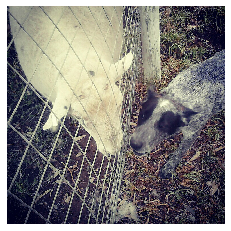

In [1169]:
imgIds = coco.getImgIds(imgIds = [img_id])
sample = coco.loadImgs(imgIds[0])[0]
I = io.imread(sample['coco_url'])
plt.imshow(I);
plt.axis('off');

In [1092]:
# catIds = coco.getCatIds(catNms=['cat','dog']);
# catIds

In [1120]:
catIds = [categories[0], categories[1]]
catIds

[17, 18]

In [1121]:
print(coco.cats[catIds[0]])
print(coco.cats[catIds[1]])

{'supercategory': 'animal', 'id': 17, 'name': 'cat'}
{'supercategory': 'animal', 'id': 18, 'name': 'dog'}


In [1122]:
# I = Image.open("../class_sensitivity/images/catdog{}.jpeg".format(img_num))

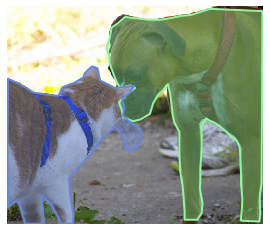

In [1123]:
# I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
annIds = coco.getAnnIds(imgIds=img_id, catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [1124]:
mask = {coco.cats[catIds[0]]["name"]:0, coco.cats[catIds[1]]["name"]:0}

for seg in anns:
    if seg["category_id"] == coco.getCatIds(catNms=coco.cats[catIds[0]]["name"])[0]:
        mask[coco.cats[catIds[0]]["name"]] = coco.annToMask(seg)
    elif seg["category_id"] == coco.getCatIds(catNms=coco.cats[catIds[1]]["name"])[0]:
        mask[coco.cats[catIds[1]]["name"]] = coco.annToMask(seg)
    else:
        pass


In [1125]:
mask = {k: torch.tensor(v, dtype=torch.float) for k,v in mask.items()}

In [1126]:
# transform masks
mask = {k: transforms.CenterCrop(224)(transforms.Resize(256)(v.unsqueeze(0))) for k,v in mask.items()}

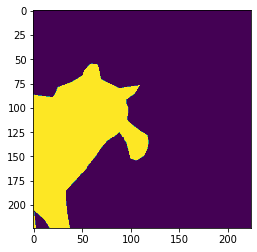

In [1127]:
plt.imshow(mask[coco.cats[catIds[0]]["name"]].squeeze())

In [1128]:
file = open("imagnet_classes.txt", "r")

contents = file.read()
imagenet_classes = ast.literal_eval(contents)

file.close()

print(type(imagenet_classes))

<class 'dict'>


In [1129]:
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()
model_softplus = convert_relu_to_softplus(model, beta=0.8)
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

In [1130]:

img = torchvision.transforms.ToTensor()(
            torchvision.transforms.CenterCrop(224)(torchvision.transforms.Resize(256)(Image.fromarray(I))))
img = normalizer.forward(img.unsqueeze(0)).to(device)

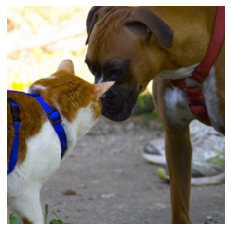

In [1131]:
plt.imshow(torch_to_image(img, data_mean, data_std));
plt.axis('off');

In [1132]:
sigma = (torch.max(img) - torch.min(img)).item() * 0.2

In [1133]:
sigma

0.9447309494018555

In [1134]:
model(img).argsort(descending=True)[:,:40]

tensor([[242, 253, 171, 180, 172, 179, 173, 676, 243, 159, 195, 158, 211, 166,
         246, 245, 151, 852, 237, 167, 339, 805, 238, 254, 247, 168, 262, 560,
         353, 162, 236, 225, 176, 268, 163,  97, 429, 161, 184, 352]],
       device='cuda:0')

In [1068]:
ind1=274
ind2=280

In [1069]:
print(ind1, imagenet_classes[ind1])
print(ind2, imagenet_classes[ind2])

274 dhole, Cuon alpinus
280 grey fox, gray fox, Urocyon cinereoargenteus


In [1031]:
ind_2_cat = {ind1: coco.cats[catIds[1]]["name"], ind2:coco.cats[catIds[0]]["name"]}
ind_2_cat

{151: 'dog', 282: 'cat'}

In [1032]:
inds = list(model(img).argsort(descending=True)[:,:10].squeeze().cpu().numpy())

In [1033]:
F.softmax(model(img), dim=1)[0, inds]

tensor([0.0352, 0.0350, 0.0336, 0.0308, 0.0306, 0.0235, 0.0233, 0.0228, 0.0210,
        0.0187], device='cuda:0', grad_fn=<IndexBackward>)

In [1034]:
def unravel_index(
    # to unravel the flatten index to tensor indices
    indices: torch.LongTensor,
    shape: (int, ...),
) -> torch.LongTensor:
    r"""Converts flat indices into unraveled coordinates in a target shape.

    This is a `torch` implementation of `numpy.unravel_index`.

    Args:
        indices: A tensor of (flat) indices, (*, N).
        shape: The targeted shape, (D,).

    Returns:
        The unraveled coordinates, (*, N, D).
    """

    coord = []

    for dim in reversed(shape):
        coord.append(indices % dim)
        indices = indices // dim

    coord = torch.stack(coord[::-1], dim=-1)

    return coord

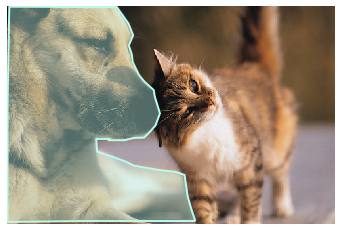

In [1035]:
plt.axis('off')
plt.imshow(I)
annIds = coco.getAnnIds(imgIds=img_id, catIds=coco.getCatIds(catNms=coco.cats[catIds[0]]["name"]), iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)
plt.savefig("temp_ann_obj1.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.close()
###
plt.axis('off')
plt.imshow(I)
annIds = coco.getAnnIds(imgIds=img_id, catIds=coco.getCatIds(catNms=coco.cats[catIds[1]]["name"]), iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)
plt.savefig("temp_ann_obj2.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05)

In [1036]:
obj1_ann = Image.open("temp_ann_obj1.jpg")
obj1_ann_img = torchvision.transforms.CenterCrop(224)(torchvision.transforms.Resize(256)(obj1_ann))

In [1037]:
obj2_ann = Image.open("temp_ann_obj2.jpg")
obj2_ann_img = torchvision.transforms.CenterCrop(224)(torchvision.transforms.Resize(256)(obj2_ann))

In [1038]:
img_ann = {coco.cats[catIds[0]]["name"]: obj1_ann_img, coco.cats[catIds[1]]["name"]: obj2_ann_img}

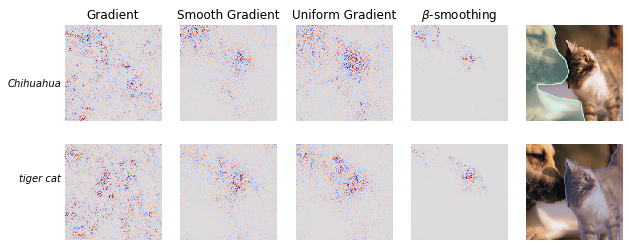

In [1039]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
grad_top5_indices={}
sg_top5_indices={}
ug_top5_indices={}
softplus_top5_indices={}
top_features = 20
for i, idx in enumerate([ind1, ind2]): 
    x_expl_grad = get_expl(model, img, "saliency", desired_index=idx, abs_value=False).detach().cpu()
    x_expl_sg = get_expl(model, img, "saliency", desired_index=idx, smooth=True, sigma=sigma, abs_value=False).detach().cpu()
    x_expl_ug = get_expl(model, img, "uniform_grad", desired_index=idx, sigma=sigma, abs_value=False).detach().cpu()
    torch.cuda.empty_cache()

    viz.visualize_image_attr(np.transpose(x_expl_grad.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 method='heat_map',
                                 cmap="coolwarm",
                                 show_colorbar=False,
                                 sign='all',
                                 outlier_perc=2,
                                 fig_size=(4,4), plt_fig_axis=(fig, ax[i,0]), use_pyplot=False)

    viz.visualize_image_attr(np.transpose(x_expl_sg.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 method='heat_map',
                                 cmap="coolwarm",
                                 show_colorbar=False,
                                 sign='all',
                                 outlier_perc=2,
                                 fig_size=(4,4), plt_fig_axis=(fig, ax[i,1]), use_pyplot=False)

    viz.visualize_image_attr(np.transpose(x_expl_ug.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 method='heat_map',
                                 cmap="coolwarm",
                                 show_colorbar=False,
                                 sign='all',
                                 outlier_perc=2,
                                 fig_size=(4,4), plt_fig_axis=(fig, ax[i,2]), use_pyplot=False)

    x_expl_softplus = get_expl(model_softplus, img, "saliency", desired_index=idx, abs_value=False).detach().cpu()
    viz.visualize_image_attr(np.transpose(x_expl_softplus.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 method='heat_map',
                                 cmap="coolwarm",
                                 show_colorbar=False,
                                 sign='all',
                                 outlier_perc=2,
                                 fig_size=(4,4), plt_fig_axis=(fig, ax[i,3]), use_pyplot=False)
    grad_top5_indices[idx] = unravel_index(x_expl_grad.flatten().argsort(descending=True)[:top_features], x_expl_grad.size())
    sg_top5_indices[idx] = unravel_index(x_expl_sg.flatten().argsort(descending=True)[:top_features], x_expl_sg.size())
    ug_top5_indices[idx] = unravel_index(x_expl_ug.flatten().argsort(descending=True)[:top_features], x_expl_ug.size())
    softplus_top5_indices[idx] = unravel_index(x_expl_softplus.flatten().argsort(descending=True)[:top_features], x_expl_softplus.size())

    ax[i,4].imshow(img_ann[ind_2_cat[idx]])
    for j in range(5):
        ax[i,j].axis('off')

ax[0,0].set_title("Gradient")
ax[0,1].set_title("Smooth Gradient")
ax[0,2].set_title("Uniform Gradient")
ax[0,3].set_title(r"$\beta$-smoothing")
fig.text(0.12, 0.66, imagenet_classes[ind1], style = 'oblique', fontsize = 10, horizontalalignment ='right')
fig.text(0.12, 0.33, imagenet_classes[ind2], style = 'oblique', fontsize = 10, horizontalalignment ='right')
plt.savefig("../class_sensitivity/results_new/pointing_game_id_{}.jpg".format(img_id), dpi=300, bbox_inches='tight', pad_inches=0.05);

#### pointing game experiment
Let's see if the top 5 features of the explanation are included in the bounding box.

In [1040]:
bbox = {ind1:mask[ind_2_cat[ind1]],  
        ind2:mask[ind_2_cat[ind2]]}   
bbox

{151: tensor([[[1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.]]]),
 282: tensor([[[0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          [0., 0., 0.,  ..., 1., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]])}

In [1041]:
ind_2_cat

{151: 'dog', 282: 'cat'}

In [1042]:
# i=0
in_box = {"grad":{},
"sg":{},
"ug":{},
"softplus":{}}
for j, idx in enumerate([ind1, ind2]):
    in_box["grad"][j]=0
    in_box["sg"][j]=0
    in_box["ug"][j]=0
    in_box["softplus"][j]=0
    for i in range(top_features):
        if mask[ind_2_cat[idx]][0, grad_top5_indices[idx][i][2], grad_top5_indices[idx][i][3]] == 1:
            in_box["grad"][j] += 1
        ####################
        if mask[ind_2_cat[idx]][0, sg_top5_indices[idx][i][2], sg_top5_indices[idx][i][3]] == 1:
            in_box["sg"][j] += 1
        ####################
        if mask[ind_2_cat[idx]][0, ug_top5_indices[idx][i][2], ug_top5_indices[idx][i][3]] == 1:
            in_box["ug"][j] += 1
        #####################
        if mask[ind_2_cat[idx]][0, softplus_top5_indices[idx][i][2], softplus_top5_indices[idx][i][3]] == 1:
            in_box["softplus"][j] += 1
            

In [1043]:
print(in_box)

{'grad': {0: 14, 1: 7}, 'sg': {0: 4, 1: 20}, 'ug': {0: 0, 1: 19}, 'softplus': {0: 15, 1: 19}}


In [1044]:
with open("../class_sensitivity/results_new/new_in_box_{}.json".format(img_id), "w") as f:
    json.dump(in_box, f)

#### average results

In [1159]:
i = 0
all_results = {"grad":{0:0, 1:0},
"sg":{0: 0, 1:0},
"ug":{0: 0, 1:0},
"softplus":{0: 0, 1:0}}
for f in os.listdir("../class_sensitivity/results_new/"):
    if f.startswith("in_box") or f.startswith("new_in_box"):
        i = i+1
        with open("../class_sensitivity/results_new/"+f, "r") as fp:
            box = json.load(fp)
        for method in ["grad", "sg", "ug", "softplus"]:
            for _ in [0,1]:
                all_results[method][_] += box[method][str(_)]


In [1160]:
i

57

In [1161]:
{k1: {k2:v2/(20*i) for k2,v2 in v1.items()} for k1,v1 in all_results.items()}

{'grad': {0: 0.6087719298245614, 1: 0.48771929824561405},
 'sg': {0: 0.5368421052631579, 1: 0.37456140350877193},
 'ug': {0: 0.5657894736842105, 1: 0.38421052631578945},
 'softplus': {0: 0.5956140350877193, 1: 0.4535087719298246}}

In [1172]:
i = 0
all_results = {"grad":{0:[], 1:[]},
"sg":{0: [], 1:[]},
"ug":{0: [], 1:[]},
"softplus":{0: [], 1:[]}}
for f in os.listdir("../class_sensitivity/results_new/"):
    if f.startswith("in_box") or f.startswith("new_in_box"):
        i = i+1
        with open("../class_sensitivity/results_new/"+f, "r") as fp:
            box = json.load(fp)
        for method in ["grad", "sg", "ug", "softplus"]:
            for _ in [0,1]:
                all_results[method][_].append(box[method][str(_)])


In [1173]:
{k1: {k2:np.mean(v2)/20 for k2,v2 in v1.items()} for k1,v1 in all_results.items()}

{'grad': {0: 0.6087719298245614, 1: 0.48771929824561405},
 'sg': {0: 0.5368421052631579, 1: 0.37456140350877193},
 'ug': {0: 0.5657894736842105, 1: 0.38421052631578945},
 'softplus': {0: 0.5956140350877193, 1: 0.4535087719298246}}

In [1174]:
{k1: {k2:np.std(v2)/20 for k2,v2 in v1.items()} for k1,v1 in all_results.items()}

{'grad': {0: 0.3674381207025185, 1: 0.36301378613741836},
 'sg': {0: 0.3615908218382667, 1: 0.33101688182654754},
 'ug': {0: 0.3628781022356945, 1: 0.34718894885204243},
 'softplus': {0: 0.38105125843828713, 1: 0.3804267743269493}}

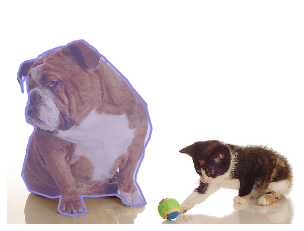

In [214]:
plt.axis('off')
plt.imshow(I)
annIds = coco.getAnnIds(imgIds=img_id, catIds=[18], iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)
plt.savefig("temp_ann_dog.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05)

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


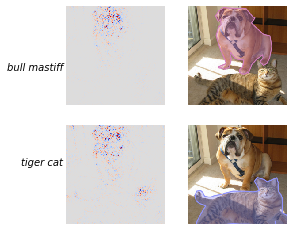

In [66]:
# fig for the paper
fig, ax = plt.subplots(2, 2, figsize=(4, 4))
for i, idx in enumerate([ind1, ind2]): #dog, cat

    x_expl_softplus = get_expl(model_softplus, img, "saliency", desired_index=idx, abs_value=False).detach().cpu()
    viz.visualize_image_attr(np.transpose(x_expl_softplus.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 method='heat_map',
                                 cmap="coolwarm",
                                 show_colorbar=False,
                                 sign='all',
                                 outlier_perc=2,
                                 fig_size=(4,4), plt_fig_axis=(fig, ax[i,0]), use_pyplot=False)
    
    ax[i,1].imshow(img_ann[ind_2_cat[idx]])
    for j in range(2):
        ax[i,j].axis('off')
fig.text(0.12, 0.66, imagenet_classes[ind1], style = 'oblique', fontsize = 10, horizontalalignment ='right')
fig.text(0.12, 0.33, imagenet_classes[ind2], style = 'oblique', fontsize = 10, horizontalalignment ='right')
plt.savefig("pointing_game.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

In [ ]:
unravel_index(a.flatten().argsort(descending=True)[:3], a.size())

In [ ]:
a.flatten().argsort(descending=True)